In [ ]:
import pytorch_lightning as pl
import torchvision
import torch 

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split


class FlowerDataModule(pl.LightningDataModule):
    def __init__(self, data_dir = '/content/drive/MyDrive/flower/flowers'):
        super().__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose(
          [   
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.1),
            transforms.RandomRotation(10),
              transforms.ToTensor(),
              transforms.Normalize(
                  mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
              ),
          ]
        )

    def setup(self, stage= None):
        flower_full = ImageFolder(self.data_dir, transform = self.transform)
    
        length = len(flower_full)
    
        val_split_size = 0.2
        
        train_length = round(length * (1 - val_split_size))
        val_length = length - train_length
    
        self.flower_train, self.flower_val = \
          random_split(flower_full , [train_length, val_length])  

    def train_dataloader(self):
        train_dataloader = \
          DataLoader(self.flower_train, batch_size = 32, shuffle = True)

        return train_dataloader

    def val_dataloader(self):  
        val_dataloader = \
          DataLoader(self.flower_val, batch_size = 32)

        return val_dataloader


In [6]:
flower_dm = FlowerDataModule()

flower_dm.setup()

In [ ]:
# Model is frozen for initial 10 epochs and unfrozen after

from pl_bolts.models.self_supervised import SwAV
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy
from torch.optim import Adam


class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
        swav = SwAV.load_from_checkpoint(weight_path, strict = True)

        self.backbone = swav.model
        self.finetune_layer = torch.nn.Linear(3000, num_classes)
        
    def training_step(self, batch, batch_idx):
        x, y = batch

        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                  features = self.backbone(x)[-1]
        else:
            features = self.backbone(x)[-1]

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y, task='multiclass', num_classes=self.hparams.num_classes)

        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch   

        features = self.backbone(x)[-1]
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return metrics

    def configure_optimizers(self):
        
        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

In [ ]:
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger(save_dir = './lightning_logs', name = 'swav_bb_unfrozen')

In [ ]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(max_epochs = 20, logger = logger)

trainer.fit(classifier, flower_dm)  

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 28.4 M
1 | finetune_layer | Linear | 15.0 K
------------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params
113.479   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


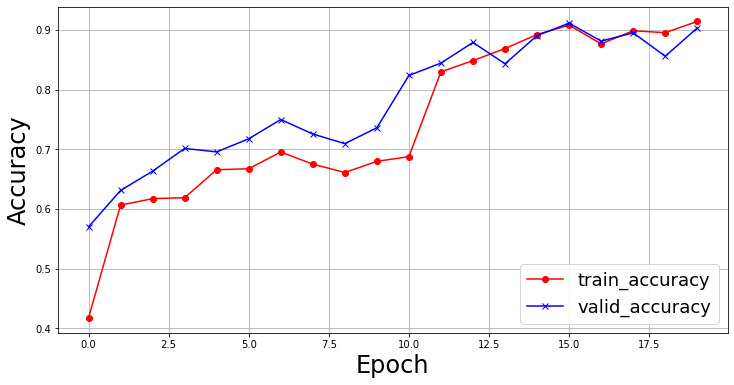

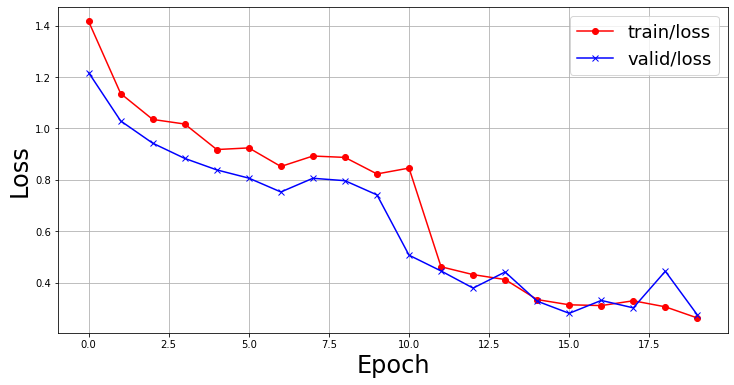

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)
    
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_ssl_swav.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_ssl_swav.png')\

In [ ]:
from torch.utils.data import Dataset


class ApplyTransform(Dataset):
   
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform
        

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [ ]:
from pl_bolts.models.self_supervised.swav import (
    SwAVTrainDataTransform, SwAVEvalDataTransform
)
from pl_bolts.transforms.dataset_normalizations import stl10_normalization


train_transform = SwAVTrainDataTransform(normalize = stl10_normalization())
val_transform = SwAVEvalDataTransform(normalize = stl10_normalization())

In [ ]:
class FlowerDataModule(pl.LightningDataModule):
    def __init__(self, train_transform, val_transform, data_dir = '../datasets/flowers'):
        super().__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose([torchvision.transforms.Resize((224, 224))])

        self.train_transform = train_transform
        self.val_transform = val_transform

    def setup(self, stage = None):
        flower_full = ImageFolder(self.data_dir, transform = self.transform)
    
        length = len(flower_full)
    
        val_split_size = 0.2
        
        train_length = round(length * (1 - val_split_size))
        val_length = length - train_length
    
        self.flower_train, self.flower_val = \
            random_split(flower_full , [train_length, val_length])

        self.flower_train = ApplyTransform(self.flower_train, transform = self.train_transform)
        self.flower_val = ApplyTransform(self.flower_val, transform = self.val_transform)

    def train_dataloader(self):
        train_dataloader = \
          DataLoader(self.flower_train, batch_size = 32, shuffle = True)

        return train_dataloader

    def val_dataloader(self):  
        val_dataloader = \
          DataLoader(self.flower_val, batch_size = 32)

        return val_dataloader


In [14]:
flower_dm_swav = FlowerDataModule(train_transform , val_transform)

flower_dm_swav.setup()

In [15]:
train_dl = flower_dm_swav.train_dataloader()

len(train_dl)

109

In [ ]:
class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
        swav = SwAV.load_from_checkpoint(weight_path, strict = True)

        self.backbone = swav.model
        self.finetune_layer = torch.nn.Linear(3000, num_classes)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x[0]

        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                  features = self.backbone(x)[-1]
        else:
            features = self.backbone(x)[-1]

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y, task='multiclass', num_classes=self.hparams.num_classes)

        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch   
        x = x[0]

        features = self.backbone(x)[-1]
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y)

        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return metrics

    def configure_optimizers(self):
        
        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

In [18]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'swav_bb_unfrozen_with_swavtransform')

In [ ]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(max_epochs = 20, 
                     limit_train_batches = 20, 
                     log_every_n_steps = 10,
                     logger = logger, gpus = 1)

trainer.fit(classifier, flower_dm_swav)  

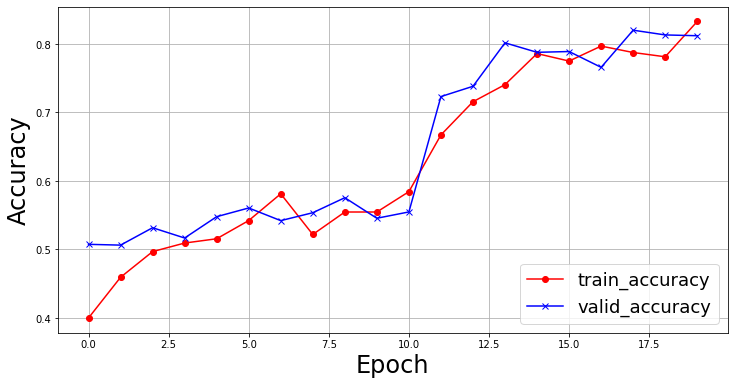

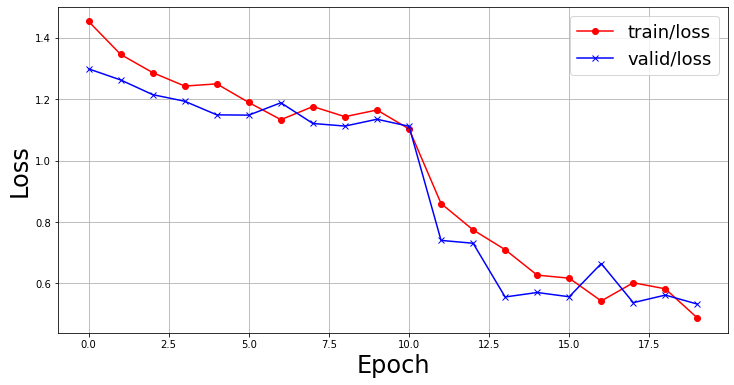

In [ ]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)
    
fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_ssl_swav_tr.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_ssl_swav_tr.png')

![](img/20201117-1-train_acc.svg "Train Accuracy")

![](img/20201117-1-train_loss.svg "Train Loss")